In [3]:
import tensorflow as tf
from keras import layers
from keras.models import Model

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = layers.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [4]:
from keras import backend as K

def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                            mean=0., stddev=0.1)
  return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling) ([z_mean, z_log_sigma])

In [5]:
# Create encoder
encoder_vae = Model(inputs, [z_mean, z_log_sigma, z])

# Create decoder
latent_inputs = layers.Input(shape=(latent_dim), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder_vae = Model(latent_inputs, outputs)

# instantiate VAE model
outputs = decoder_vae(encoder_vae(inputs)[2])
vae = Model(inputs, outputs)

In [6]:
# Loss function
from keras import losses

reconstruction_loss = losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [7]:
# data
import numpy as np
from keras.datasets import mnist

def preprocess(array):
  array = array.astype("float32") / 255.0
  array = np.reshape(array, (len(array), -1))
  return array

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_n = preprocess(x_train)
x_test_n = preprocess(x_test)

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
# fit
vae.fit(x_train_n, x_train_n,
        epochs=10, batch_size=32,
        validation_data=(x_test_n, x_test_n))

Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 186.4794 - val_loss: 168.1096
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 165.5520 - val_loss: 164.0638
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 162.3570 - val_loss: 161.4483
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 160.2353 - val_loss: 159.6767
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 158.4636 - val_loss: 157.9973
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 156.9473 - val_loss: 156.4318
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 155.7202 - val_loss: 155.6998
Epoch 8/10
1875/1875 [==============================] - 16s 9ms/step - loss: 154.7968 - val_loss: 154.8417
Epoch 9/10
1875/1875 [==============================] - 16s 9ms/step - loss: 154.0769 - val_loss: 154.0137
Epoch 10/10
1875/1875 [==============

313/313 [==============================] - 1s 4ms/step


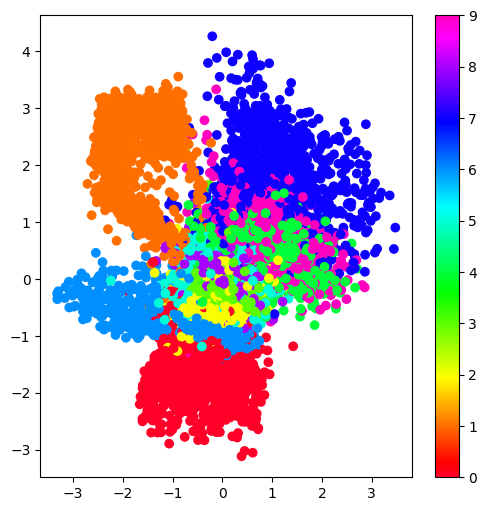

In [12]:
# Result
import matplotlib.pyplot as plt

x_test_encoded = encoder_vae.predict(x_test_n, batch_size=32)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[2][:,0], x_test_encoded[2][:,1], c=y_test, cmap='gist_rainbow')
plt.colorbar()
plt.show()

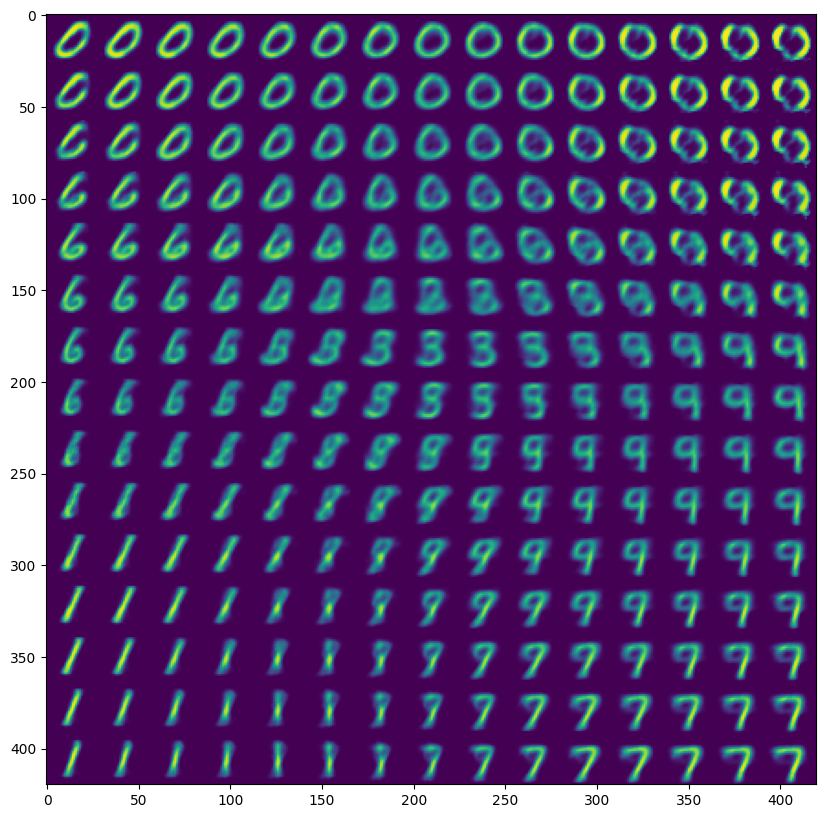

In [14]:
# Display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder_vae.predict(z_sample, verbose=0)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()